# <span style="color:green">Welcome to Tensorflow Tutorial</span>

In [24]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib import slim 
from tensorflow.python.ops import init_ops
tf.logging.set_verbosity('ERROR')
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib.pyplot import imshow
import os
import numpy as np
%matplotlib inline
# number 1 to 10 data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# <span style="color:green">Awesome! Now, you get mnist dataset!</span>

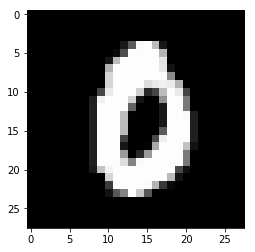

In [25]:
#show image
batch_xs, batch_ys = mnist.train.next_batch(1)
batch_xs=(batch_xs.reshape(28,28)*255).astype(np.uint)
imshow(batch_xs, cmap='gray')

In [27]:
batch_ys

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [28]:
#define input tensor and Variable
xs = tf.placeholder(tf.float32, [None, 784]) # 28x28
ys = tf.placeholder(tf.float32, [None, 10])

keep_prob_tensor = tf.placeholder(tf.float32)  #dropout 
learning_rate_tensor=tf.placeholder(tf.float32)
global_step = tf.Variable(0, name='global_step', trainable=False)
x_image = tf.reshape(xs, [-1, 28, 28, 1])
define_model=False
log_path='/data4/DR/Tutorial/log'

In [30]:
batch_ys

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

# <span style="color:green">Now! build your own model!</span>

In [5]:
with tf.variable_scope("Tensorflow_Tutorial") as scope:
    if define_model==True:
        tf.get_variable_scope().reuse_variables()
    #start define model
    #convolution layer-output 32 kernals, kernal size 5 X 5, stride 2,activation_fn=relu
    net=slim.conv2d(x_image,32,[5,5],2,weights_initializer=init_ops.truncated_normal_initializer(stddev=0.1)
                    ,biases_initializer=init_ops.Constant(0.1),
                    activation_fn=tf.nn.relu,padding='SAME',scope='conv_1')
    #pool layer-max pool with 2 X 2
    net=slim.max_pool2d(net,[2,2],scope='max_pool_1')
    net=slim.conv2d(net,64,[5,5],2,weights_initializer=init_ops.truncated_normal_initializer(stddev=0.1),
                    biases_initializer=init_ops.Constant(0.1),scope='conv_2')
    net=slim.max_pool2d(net,[2,2],scope='max_pool_2')
    #fully connected layer-output 1024
    net=slim.fully_connected(net,1024,scope='fc_1',weights_initializer=init_ops.truncated_normal_initializer(stddev=0.1),
                            biases_initializer=init_ops.Constant(0.1))
    #flatten
    net=slim.flatten(net, scope='PreLogitsFlatten')
    net=tf.nn.dropout(net,keep_prob_tensor)
    #result without softmax
    logit=slim.fully_connected(net,10,scope='fc_2',weights_initializer=init_ops.truncated_normal_initializer(stddev=0.1),
                              biases_initializer=init_ops.Constant(0.1))
    
    define_model=True
    
    #define loss
    loss=slim.losses.softmax_cross_entropy(logit,ys)
    #define optimizer for training
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_tensor)
    #define train operator
    train_op = slim.learning.create_train_op(loss, optimizer,global_step)
    
    prediction=tf.arg_max(logit,1)
    accuracy=slim.metrics.accuracy(tf.arg_max(logit,1),tf.arg_max(ys,1))
    
    #define summary for tensorboard
    tf.summary.scalar('Loss',loss)
    tf.summary.scalar('accuracy',accuracy)
    summary_op=tf.summary.merge_all()
    #get variables which need to be initialed 
    variables_for_init=tf.global_variables_initializer()
    
    

In [6]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1  #0.1 =GPU_memory usage
sess = tf.Session(config=config) #start Session 
#Session.run(require tensorflow run something  )
sess.run(variables_for_init)     #initiaal variables 
writer_master = tf.summary.FileWriter(log_path, sess.graph)   #define summary writer for tensorboard

# <span style="color:green">Must initial variables before anything!</span>

In [7]:
#sess = tf.Session()
#sess.run(variables_for_init)
#writer_master = tf.summary.FileWriter(log_path, sess.graph)

# <span style="color:green">Tuning parameters!</span>

In [15]:
Steps=2000
learning_rate=0.0001
keep_prob=0.5
valid=100

# <span style="color:green">Start training!</span>

In [18]:
for step in range(Steps):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    #session can run multi tensors -> sess.run([tensors,tensors])
    #session can run single tensors -> sess.run([tensor])
    #feed_dict -> assign data to tensor 
    '''
    useless  <- train_op
    train_loss  <-  loss
    xs  <- batch_xs
    ys  <-  batch_ys
    '''
    useless,train_loss=sess.run([train_op,loss], feed_dict={xs: batch_xs, ys: batch_ys, 
                                    keep_prob_tensor: keep_prob,learning_rate_tensor:learning_rate})
    if step % valid == 0:
        accuracy_,summary_=sess.run([accuracy,summary_op,], feed_dict={xs: mnist.test.images, ys: mnist.test.labels, 
                                      keep_prob_tensor: keep_prob,learning_rate_tensor:learning_rate})
        print ('train_loss:'+str(train_loss),'Accuracy:'+str(accuracy_))   
        #write summary to tensorboard
        #step is X
        writer_master.add_summary(summary_,step)
        #force writer write report to tensorboard
        writer_master.flush()
        
        

train_loss:3.80257 Accuracy:0.1025
train_loss:2.30768 Accuracy:0.111
train_loss:2.23507 Accuracy:0.1839
train_loss:1.81147 Accuracy:0.3603
train_loss:1.555 Accuracy:0.5626
train_loss:0.80971 Accuracy:0.6956
train_loss:0.61118 Accuracy:0.7672
train_loss:0.629698 Accuracy:0.7988
train_loss:0.387269 Accuracy:0.8721
train_loss:0.278101 Accuracy:0.8953
train_loss:0.348841 Accuracy:0.9139
train_loss:0.21623 Accuracy:0.9224
train_loss:0.138004 Accuracy:0.9285
train_loss:0.350527 Accuracy:0.9368
train_loss:0.268281 Accuracy:0.9355
train_loss:0.151027 Accuracy:0.9379
train_loss:0.280224 Accuracy:0.945
train_loss:0.216538 Accuracy:0.9493
train_loss:0.319134 Accuracy:0.9518
train_loss:0.248271 Accuracy:0.9526


In [12]:
batch_xs, batch_ys = mnist.train.next_batch(1)

In [16]:
#predict the result
prediction_=sess.run(prediction, feed_dict={xs: batch_xs, 
                                    keep_prob_tensor: keep_prob,learning_rate_tensor:learning_rate})

In [17]:
prediction_

array([1])

# <span style="color:green">Now! Save your own model!</span>

In [9]:
#define saver for save model variables from sess
Saver=tf.train.Saver()
model_path=os.path.join(log_path,'model.ckpt')
Saver.save(sess,model_path)

'/data4/DR/Tutorial/log/model.ckpt'

In [11]:
#restore model variables for sess
# you must initial model variables before restore
Saver.restore(sess,model_path)

In [ ]:
#type following instruction on the command line to run tensorboard
tensorboard --logdir=/data4/DR/Tutorial/log